In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [491]:
train_df = pd.read_csv('train.csv')
age_gender_df = pd.read_csv('age_gender_info.csv')
test_df = pd.read_csv('test.csv')

## 기본 전처리
- 데이콘에서 제시한 오류 2번, 3번 제거
- 숫자형 데이터 : 0 으로 결측치 채움
- 범주형 데이터 : 같은 단지의 같은 코드로 결측치 채움
- 완전히 동일한 중복행 제거

In [492]:
def data_preprocessing(train_df, test_df):
    
    # 오류 2번, 3번만 제거 : 1번은 감안하여 분석 하세요!
    error_data = error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
    
    for error in error_data :
        train_df = train_df[train_df['단지코드'] != error]
    
    train_df.loc[train_df['임대보증금'] == '-','임대보증금'] = np.nan
    train_df.loc[train_df['임대료'] == '-','임대료'] = np.nan

    train_df['임대보증금'] = train_df['임대보증금'].astype(float)
    train_df['임대료'] = train_df['임대료'].astype(float)
    
    cols = ['임대보증금', '임대료','도보 10분거리 내 지하철역 수(환승노선 수 반영)','도보 10분거리 내 버스정류장 수']

    train_df[cols] = train_df[cols].fillna(0)
    test_df[cols] = test_df[cols].fillna(0)
    
    test_df[ (test_df['단지코드']=='C2411') & (test_df['자격유형'].isnull())] = 'A'
    test_df[ (test_df['단지코드']=='C2253') & (test_df['자격유형'].isnull())] = 'C'
    
    train_df = train_df.drop_duplicates()
    test_df = test_df.drop_duplicates()
    
    
    return train_df, test_df

In [493]:
train, test = data_preprocessing(train_df, test_df)

In [494]:
train.shape, test.shape

((2556, 15), (949, 14))

In [495]:
train.set_index('단지코드', drop=True,inplace=True)

### 범주형 데이터 전처리
- 원핫인코딩

In [496]:
train = pd.get_dummies(train)

In [497]:
train.columns # 임대건물구분, 지역, 공급유형, 자격유형 -> 범주형 변수를 원핫인코딩으로 처리.

Index(['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수',
       '등록차량수', '임대건물구분_상가', '임대건물구분_아파트', '지역_강원도', '지역_경기도', '지역_경상남도',
       '지역_경상북도', '지역_광주광역시', '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시',
       '지역_세종특별자치시', '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도',
       '지역_충청북도', '공급유형_공공분양', '공급유형_공공임대(10년)', '공급유형_공공임대(50년)',
       '공급유형_공공임대(5년)', '공급유형_공공임대(분납)', '공급유형_국민임대', '공급유형_영구임대', '공급유형_임대상가',
       '공급유형_장기전세', '공급유형_행복주택', '자격유형_A', '자격유형_B', '자격유형_C', '자격유형_D',
       '자격유형_E', '자격유형_F', '자격유형_G', '자격유형_H', '자격유형_I', '자격유형_J', '자격유형_K',
       '자격유형_L', '자격유형_M', '자격유형_N', '자격유형_O'],
      dtype='object')

### 데이터 분리

In [498]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

y_target = train['등록차량수']
X_data = train.drop('등록차량수',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=0)

### LinearRegression 이용한 회귀모델
- 평가지표는 대회에서 정한 MAE로 측정

In [499]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
print(mae)

134.36078705237819


In [500]:
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

공급유형_공공분양                       515.9
자격유형_D                          324.6
지역_세종특별자치시                      276.4
공급유형_공공임대(분납)                   251.0
자격유형_I                          192.9
임대건물구분_아파트                      191.4
공급유형_공공임대(10년)                  122.6
지역_경상북도                         113.0
지역_광주광역시                        101.7
자격유형_K                          101.1
자격유형_H                           83.6
지역_대구광역시                         81.8
공급유형_공공임대(5년)                    70.5
자격유형_E                           43.4
자격유형_C                           37.4
자격유형_A                           35.7
도보 10분거리 내 버스정류장 수                8.0
단지내주차면수                           0.8
전용면적별세대수                          0.1
총세대수                              0.1
자격유형_O                            0.0
임대보증금                            -0.0
임대료                               0.0
전용면적                             -0.1
공급유형_장기전세                        -0.3
지역_경기도                           -1.3
지역_전라남도     

### 교차검증
- scoring = 'neg_mean_absolute_error' 
- 일반적으로 scoring을 값이 클 수록 모델 성능이 좋은 것으로 사이킷런에서 인식하는데,
- mae는 값이 클 수록 모델 성능이 저하되는 것이므로 Negative 키워드를 붙여서 사용
- 값은 양수로 보기 위해 -1 곱함

In [501]:
# 교차 검증
from sklearn.model_selection import cross_val_score

mae_scores = -1 * cross_val_score(lr, X_data, y_target, scoring='neg_mean_absolute_error',cv=5)

print(mae_scores)
print(np.mean(mae_scores))

[254.46306275 137.83352433 119.121148   174.02640801 246.29458308]
186.34774523513798


### 릿지와 라쏘 규제
- 회귀계수 값의 차이가 너무 크게 남.
- 규제 적용을 해보자

In [502]:

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)

mae_scores = -1 * cross_val_score(ridge, X_data, y_target, scoring='neg_mean_absolute_error',cv=5)


print(mae_scores)
print(np.mean(mae_scores))

[263.06846595 138.66787736 119.42754998 169.25500872 209.83412229]
180.05060485963511


In [503]:
# 회귀계수 값의 차이가 너무 크게 나서,
# 규제 적용을 해보자

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10)

mae_scores = -1 * cross_val_score(lasso, X_data, y_target, scoring='neg_mean_absolute_error',cv=5)

print(mae_scores)
print(np.mean(mae_scores))

[278.52890251 140.1565933  110.83523215 173.35395185 171.25191903]
174.82531976977975


In [504]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=10)

mae_scores = -1 * cross_val_score(elastic, X_data, y_target, scoring='neg_mean_absolute_error',cv=5)

print(mae_scores)
print(np.mean(mae_scores))

[273.80517017 139.91008926 111.24267413 172.83100692 171.84234941]
173.92625797856505


### 결과
- LinearRegression : 186.3
- Ridge : 180.0 (alpha=10)
- Lasso : 174.8 (alpha=10)
- ElasticNet : 173.9 (alpha=10)
- (최적의 alpha 값 찾는 것도 후에 고려 필요)

**규제만으로는 여전히 에러값이 너무 큼**

## 데이터 변환 (추가 전처리)
- 선형 회귀 모델은 피처값과 타깃값의 분포가 정규분포 형태를 매우 선호.
- 특히! 타깃값의 경우 왜곡된 형태의 분포도일 경우 예측 성능에 부정적인 영향 미칠 가능성 높음.
- 데이터 스케일링/정규화 작업 필요

1. StandardScaler
2. MinMaScaler
3. log 함수
4. 다항 특성 적용

In [505]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures


def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method =='MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [506]:
def get_linear_reg_eval(model_name,params=None,X_data_n=None,y_target_n=None,verbose=True,return_coeff=True) :

    if verbose : print('####### ', model_name , '#######') # Log 출력    
    if model_name == "LinearRegression" :
        model = LinearRegression()
        neg_mae_scores = -1 * cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_absolute_error", cv = 5)
        avg_mae = np.mean(neg_mae_scores)
        print('{:.3f} '.format( avg_mae ))
    
    else:
        for param in params : # alpha값 변화
            
            if model_name =='Ridge': model = Ridge(alpha=param)
            elif model_name =='Lasso': model = Lasso(alpha=param)
            elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)

            neg_mae_scores = -1 * cross_val_score(model, X_data_n, 
                                                 y_target_n, scoring="neg_mean_absolute_error", cv = 5)
            avg_mae = np.mean(neg_mae_scores)
            print('{:.3f} '.format( avg_mae ))


In [507]:
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]

models = ['LinearRegression', 'Ridge','Lasso','ElasticNet']

alphas = [0.1,1,10,100]

In [508]:
for m in models:
    print("모델 : ", m )
    for scale_method in scale_methods:
        X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
        print("정규화 변환 : {}, 다항 계수 : {}".format(scale_method[0], scale_method[1]))
        
        get_linear_reg_eval(m,params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False )


모델 :  LinearRegression
정규화 변환 : None, 다항 계수 : None
186.348 
정규화 변환 : Standard, 다항 계수 : None
231576528271645.250 
정규화 변환 : Standard, 다항 계수 : 2
266710534660253.156 
정규화 변환 : MinMax, 다항 계수 : None
73088902854463.219 
정규화 변환 : MinMax, 다항 계수 : 2
404828811900528.125 
정규화 변환 : Log, 다항 계수 : None
214.547 
모델 :  Ridge
정규화 변환 : None, 다항 계수 : None
185.978 
184.379 
180.051 
176.606 
정규화 변환 : Standard, 다항 계수 : None
176.792 
176.651 
175.457 
171.959 
정규화 변환 : Standard, 다항 계수 : 2
473.922 
397.051 
304.427 
247.463 
정규화 변환 : MinMax, 다항 계수 : None
184.762 
179.405 
179.271 
219.276 
정규화 변환 : MinMax, 다항 계수 : 2
191.220 
156.966 
161.735 
176.160 
정규화 변환 : Log, 다항 계수 : None
210.495 
198.106 
198.110 
204.940 
모델 :  Lasso
정규화 변환 : None, 다항 계수 : None
173.710 
171.018 
174.825 
172.622 
정규화 변환 : Standard, 다항 계수 : None
174.800 
172.326 
177.385 
183.537 
정규화 변환 : Standard, 다항 계수 : 2
274.379 
165.810 
165.170 
196.775 
정규화 변환 : MinMax, 다항 계수 : None
171.440 
167.197 
165.725 
335.990 
정규화 변환 : MinMax, 다항 계수 : 2


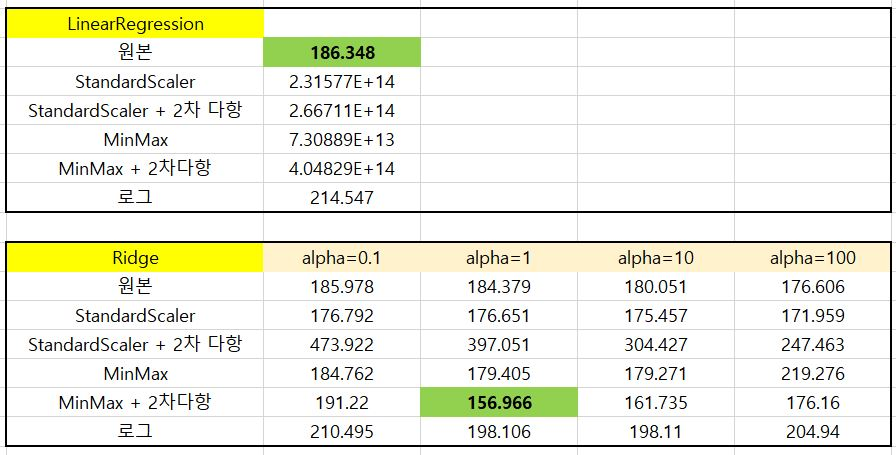

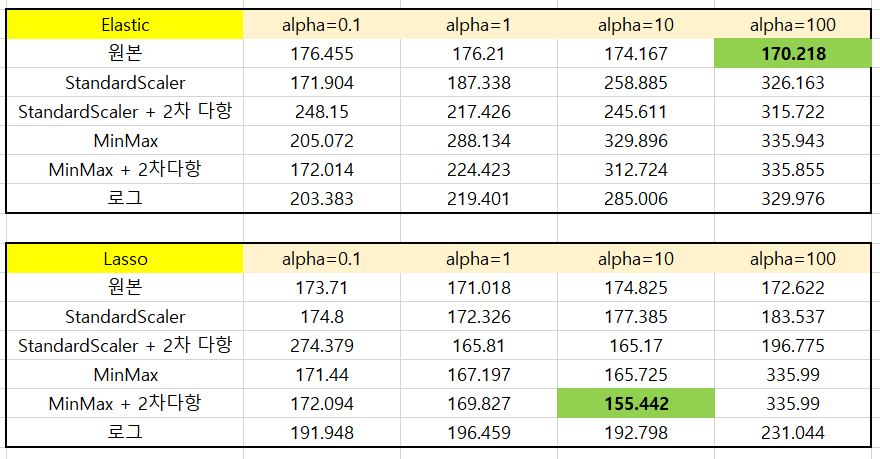

### (Lasso , alpha=10, MinMax+2차다항) 일경우 가장 높은 성능을 보임
- 기본전처리 진행
- 범주형 -> 원핫인코딩

### 타깃값 skew 제거
- 타깃값은 오른쪽 꼬리가 긴 형태.
- log 함수 적용하여 skew 제거

In [509]:
y_target_log = np.log1p(train['등록차량수']) # 타깃에 로그함수 적용
X_data = train.drop('등록차량수',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target_log, test_size=0.3, random_state=0)
y_test

단지코드
C2538    6.684612
C1885    6.424869
C1677    7.004882
C2034    4.890349
C1269    6.467699
           ...   
C2066    6.222576
C1177    6.951772
C1244    7.498316
C2086    7.329750
C2359    6.542472
Name: 등록차량수, Length: 767, dtype: float64

In [510]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)
mae  = mean_absolute_error(y_test, y_pred)
print(mae)

142.70864820721806


**타깃값 로그 적용 후, 186.3 -> 142.7 로 오류 많이 감소**

### 다른 회귀모델에 적용해보기

In [270]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if is_expm1:
        y_t = np.expm1(y_test)
        y_p = np.expm1(y_pred)
    mae = mean_absolute_error(y_t, y_p)
    print(model , mae)

In [277]:
y_target_log = np.log1p(train['등록차량수']) # 타깃에 로그함수 적용
X_data = train.drop('등록차량수',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=10)
elastic = ElasticNet(alpha=10)

# 성능 평가
models = [lr_reg, ridge_reg, lasso_reg,elastic]

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

LinearRegression() 142.70864820721806
Ridge(alpha=10) 144.64819855687585
Lasso(alpha=10) 181.81530126660655
ElasticNet(alpha=10) 182.81109379509897


### Ridge, Lasso, Elastic 최적의 파라미터 찾기

In [283]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_absolute_error', cv=5)
    grid_model.fit(X_data, y_target)
    mae = -1 *  grid_model.best_score_
    print('{0} 5 CV 시 최적 평균 로그 변환된 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [285]:
y_target = np.log1p(train['등록차량수'])
X_data = train.drop('등록차량수',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=0)
y_test

ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}
elastic_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

best_ridge=get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)
best_elastic = get_best_params(elastic,elastic_params)


Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3402, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3514, 최적 alpha:{'alpha': 0.001}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3479, 최적 alpha:{'alpha': 0.001}


In [286]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic = ElasticNet(alpha=best_elastic.alpha)

# 성능 평가
models = [lr_reg, ridge_reg, lasso_reg,elastic]

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

LinearRegression() 142.70864820721806
Ridge(alpha=0.05) 142.66605658357983
Lasso(alpha=0.001) 143.57691892633906
ElasticNet(alpha=0.001) 143.33770383870805


In [ ]:
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method =='MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

### 타깃 로그 함수 적용 + StandardScaler() + 최적 alpha 값 적용

In [311]:

y_target_log = np.log1p(train['등록차량수']) # 타깃에 로그함수 적용
X_data = train.drop('등록차량수',axis=1)
X_data = StandardScaler().fit_transform(X_data)

best_ridge=get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)
best_elastic = get_best_params(elastic,elastic_params)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic = ElasticNet(alpha=best_elastic.alpha)

models = [lr_reg, ridge_reg, lasso_reg,elastic]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target_log, test_size=0.3, random_state=0)

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)
    

Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3416, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3544, 최적 alpha:{'alpha': 0.001}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3524, 최적 alpha:{'alpha': 0.001}
LinearRegression() 143.25526029383602
Ridge(alpha=20) 141.61778093418263
Lasso(alpha=0.001) 142.087052658557
ElasticNet(alpha=0.001) 142.31358022913003


### 타깃 로그 함수 적용 + MinMaxScaler() + 최적 alpha 값 적용

In [325]:
y_target_log = np.log1p(train['등록차량수']) # 타깃에 로그함수 적용
X_data = train.drop('등록차량수',axis=1)
X_data = MinMaxScaler().fit_transform(X_data)

best_ridge=get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)
best_elastic = get_best_params(elastic,elastic_params)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic = ElasticNet(alpha=best_elastic.alpha)

models = [lr_reg, ridge_reg, lasso_reg,elastic]


X_train, X_test, y_train, y_test = train_test_split(X_data, y_target_log, test_size=0.3, random_state=0)

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)
    

Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3394, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3506, 최적 alpha:{'alpha': 0.001}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3463, 최적 alpha:{'alpha': 0.001}
LinearRegression() 142.70864819626985
Ridge(alpha=1) 141.48926081205525
Lasso(alpha=0.001) 141.76554870805123
ElasticNet(alpha=0.001) 141.39853208489427


### 타깃 로그 함수 적용 + 피처값 로그 변환 + + 최적 alpha 값 적용

In [326]:
y_target_log = np.log1p(train['등록차량수']) # 타깃에 로그함수 적용
X_data = train.drop('등록차량수',axis=1)
X_data = np.log1p(X_data)

best_ridge=get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)
best_elastic = get_best_params(elastic,elastic_params)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic = ElasticNet(alpha=best_elastic.alpha)

# 성능 평가
models = [lr_reg, ridge_reg, lasso_reg,elastic]


X_train, X_test, y_train, y_test = train_test_split(X_data, y_target_log, test_size=0.3, random_state=0)

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)
    

Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2958, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.3034, 최적 alpha:{'alpha': 0.005}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2982, 최적 alpha:{'alpha': 0.001}
LinearRegression() 128.60966080592556
Ridge(alpha=5) 129.76351252481624
Lasso(alpha=0.005) 139.05738525497375
ElasticNet(alpha=0.001) 129.80986722106863


- 타깃값과 피처값 모두 오른쪽꼬리가 긴 왼쪽으로 치우쳐진 왜곡이 존재.
- log 함수를 이용하여 skew 제거 후 성능이 많이 향상됨

### 지훈님과 비교하기 위해 만든 로그 교차검증

In [371]:
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]

models = ['LinearRegression', 'Ridge','Lasso','ElasticNet']

alphas = [0.1,1,10,100]

y_target_log = np.log1p(train['등록차량수']) # 타깃에 로그함수 적용
X_data = train.drop('등록차량수',axis=1)

for m in models:
    print("모델 : ", m )
    for scale_method in scale_methods:
        X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
        print("정규화 변환 : {}, 다항 계수 : {}".format(scale_method[0], scale_method[1]))
        
        get_linear_reg_eval(m,params=alphas, X_data_n=X_data_scaled, y_target_n=y_target_log, verbose=False, return_coeff=False )


모델 :  LinearRegression
정규화 변환 : None, 다항 계수 : None
0.340 
정규화 변환 : Standard, 다항 계수 : None
439695750546.047 
정규화 변환 : Standard, 다항 계수 : 2
486452155859.249 
정규화 변환 : MinMax, 다항 계수 : None
140158242620.649 
정규화 변환 : MinMax, 다항 계수 : 2
736234756273.567 
정규화 변환 : Log, 다항 계수 : None
0.327 
모델 :  Ridge
정규화 변환 : None, 다항 계수 : None
0.340 
0.342 
0.347 
0.366 
정규화 변환 : Standard, 다항 계수 : None
0.342 
0.342 
0.342 
0.344 
정규화 변환 : Standard, 다항 계수 : 2
0.867 
0.749 
0.625 
0.523 
정규화 변환 : MinMax, 다항 계수 : None
0.340 
0.339 
0.344 
0.417 
정규화 변환 : MinMax, 다항 계수 : 2
0.369 
0.313 
0.315 
0.357 
정규화 변환 : Log, 다항 계수 : None
0.319 
0.300 
0.298 
0.324 
모델 :  Lasso
정규화 변환 : None, 다항 계수 : None
0.419 
0.397 
0.405 
0.493 
정규화 변환 : Standard, 다항 계수 : None
0.417 
0.703 
0.703 
0.703 
정규화 변환 : Standard, 다항 계수 : 2
0.414 
0.690 
0.703 
0.703 
정규화 변환 : MinMax, 다항 계수 : None
0.601 
0.703 
0.703 
0.703 
정규화 변환 : MinMax, 다항 계수 : 2
0.569 
0.703 
0.703 
0.703 
정규화 변환 : Log, 다항 계수 : None
0.358 
0.666 
0.703 
0.703 
모델 :  Elasti

### kfold 이용하여 교차 검증 재시도
- 로그 변환 MAE 값말고, 실제 MAE값으로 비교하여 수치를 명확히 확인하기위해.

In [487]:
from sklearn.model_selection import KFold

train_df = pd.read_csv('train.csv')
age_gender_df = pd.read_csv('age_gender_info.csv')
test_df = pd.read_csv('test.csv')
train, test = data_preprocessing(train_df, test_df)

train = train.reset_index(drop=True)

y_target = train['등록차량수']
X_data = train.drop('등록차량수',axis=1)
X_data = pd.get_dummies(X_data)
X_data_log = np.log1p(X_data)
y_target_log = np.log1p(y_target)

# X_data_log.head()
# y_target_log

In [488]:
kfold = KFold(n_splits=5)
lr_reg = LinearRegression()
cv_mae=[]


In [489]:
n_iter = 0 

for train_index, test_index in kfold.split(X_data_log):
    X_train, X_test = X_data_log.iloc[train_index], X_data_log.iloc[test_index]
    y_train, y_test = y_target_log[train_index], y_target_log[test_index]
    # 학습 및 예측
    
    lr_reg.fit(X_train, y_train)
    y_pred = lr_reg.predict(X_test)
    n_iter += 1
    y_t = np.expm1(y_test)
    y_p = np.expm1(y_pred)
    
    mae = mean_absolute_error(y_t,y_p)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('\n#{0} 교차 검증 MAE :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'.format(n_iter, mae, train_size, test_size))
    cv_mae.append(mae)
# 개별 iteration별 정확도를 합하여 평균 정확도 계산
print('\n## 평균 검증 MAE:', np.mean(cv_mae))


#1 교차 검증 MAE :148.17974367703593, 학습 데이터 크기: 2044, 검증 데이터 크기: 512

#2 교차 검증 MAE :147.85181210735792, 학습 데이터 크기: 2045, 검증 데이터 크기: 511

#3 교차 검증 MAE :132.47851187656008, 학습 데이터 크기: 2045, 검증 데이터 크기: 511

#4 교차 검증 MAE :157.00344970484701, 학습 데이터 크기: 2045, 검증 데이터 크기: 511

#5 교차 검증 MAE :187.64296381024167, 학습 데이터 크기: 2045, 검증 데이터 크기: 511

## 평균 검증 MAE: 154.6312962352085


### 계수 시각화

In [327]:
def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=X_data.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10) # 회귀계수가 큰 10개
    coef_low = coef.sort_values(ascending=False).tail(10) # -로 표현된 회귀계수에서 절대값이 큰 10개
    
    return coef_high, coef_low

In [328]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=4)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

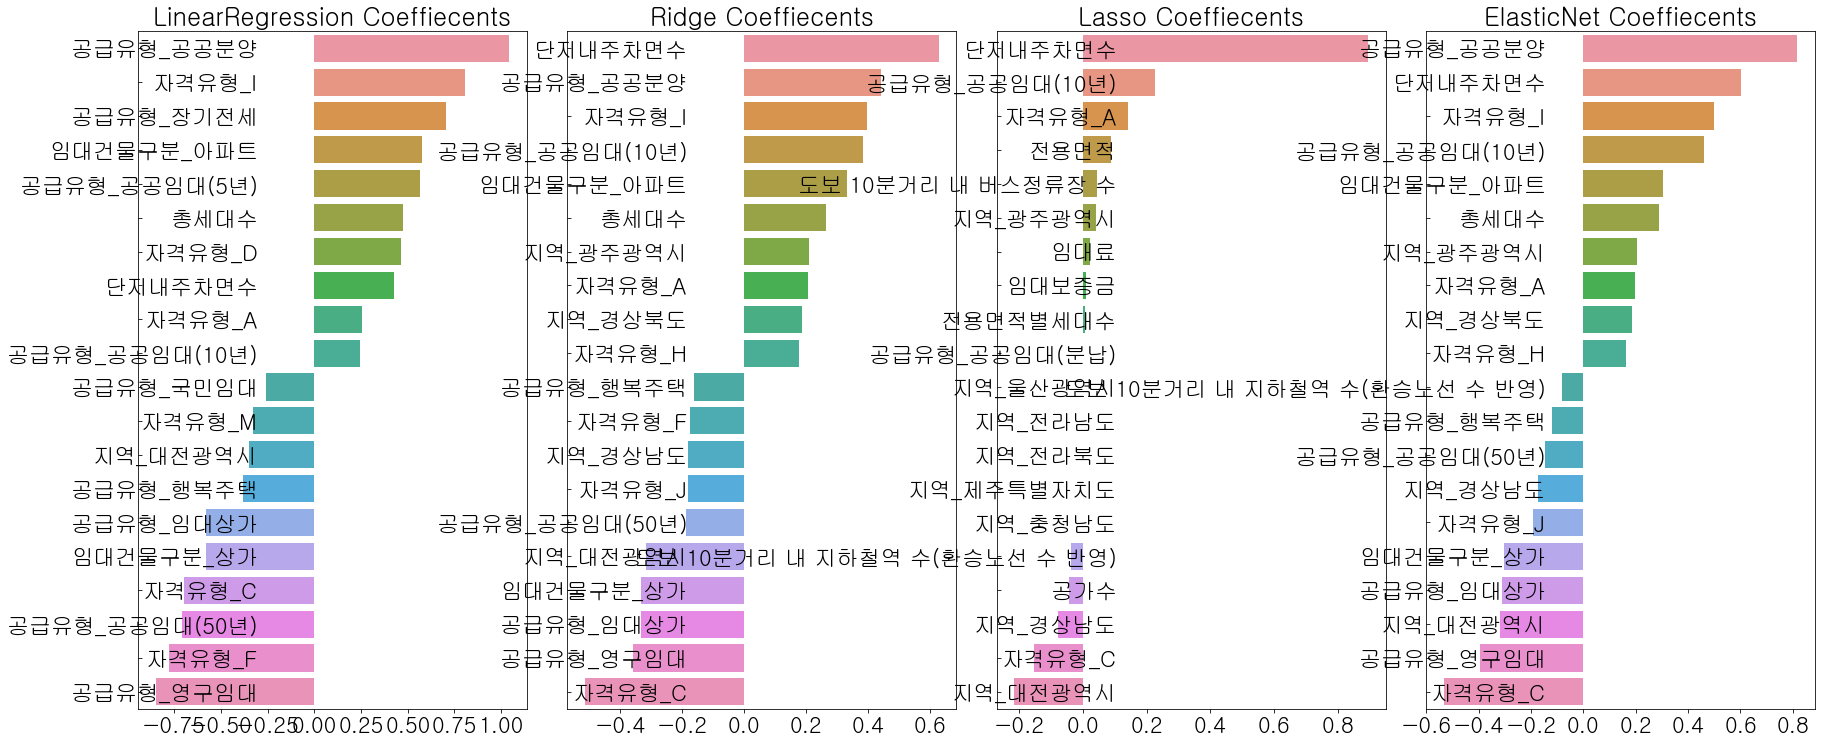

In [329]:
models = [lr_reg, ridge_reg, lasso_reg , elastic]
visualize_coefficient(models)

### 상관성이 높은 피처 제거 후 재평가

In [479]:
train_df = pd.read_csv('train.csv')
age_gender_df = pd.read_csv('age_gender_info.csv')
test_df = pd.read_csv('test.csv')


In [480]:
train, test = data_preprocessing(train_df, test_df)
train.set_index('단지코드', drop=True,inplace=True)

In [481]:
corr_df = train.corr()
corr_df

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
총세대수,1.000000,0.061466,0.170553,0.106555,-0.072037,-0.100135,0.132821,0.038666,0.619023,0.433674
전용면적,0.061466,1.000000,-0.069378,-0.105593,0.107666,0.169341,0.003153,-0.001529,0.024190,0.071716
전용면적별세대수,0.170553,-0.069378,1.000000,0.146410,0.029523,0.087320,-0.025357,0.053276,0.237925,0.196216
공가수,0.106555,-0.105593,0.146410,1.000000,0.161840,-0.032658,-0.113684,0.051127,0.308712,0.108960
임대보증금,-0.072037,0.107666,0.029523,0.161840,1.000000,0.589127,-0.008649,0.124869,0.300213,0.349826
임대료,-0.100135,0.169341,0.087320,-0.032658,0.589127,1.000000,0.017883,0.056935,0.344675,0.472451
도보 10분거리 내 지하철역 수(환승노선 수 반영),0.132821,0.003153,-0.025357,-0.113684,-0.008649,0.017883,1.000000,0.104026,-0.020911,-0.058399
도보 10분거리 내 버스정류장 수,0.038666,-0.001529,0.053276,0.051127,0.124869,0.056935,0.104026,1.000000,0.103797,0.125265
단지내주차면수,0.619023,0.024190,0.237925,0.308712,0.300213,0.344675,-0.020911,0.103797,1.000000,0.848783
등록차량수,0.433674,0.071716,0.196216,0.108960,0.349826,0.472451,-0.058399,0.125265,0.848783,1.000000


**임대료와 임대보증금은 높은 상관관계를 가지므로 한 피처는 삭제**

- 등록차량수(타깃)와 임대료가 더 높은 상관관계를 가지므로 임대보증금을 삭제하도록 한다.

In [483]:

y_target_log = np.log1p(train['등록차량수'])
X_data = train.drop(['등록차량수','임대보증금'],axis=1)
X_data = pd.get_dummies(X_data)
X_data = np.log1p(X_data)

best_ridge=get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)
best_elastic = get_best_params(elastic,elastic_params)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic = ElasticNet(alpha=best_elastic.alpha)

# 성능 평가
models = [lr_reg, ridge_reg, lasso_reg,elastic]


X_train, X_test, y_train, y_test = train_test_split(X_data, y_target_log, test_size=0.3, random_state=0)

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)
    

Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 196.9162, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 189.2581, 최적 alpha:{'alpha': 10}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 196.954, 최적 alpha:{'alpha': 0.005}
LinearRegression() 128.41311665172765
Ridge(alpha=5) 129.72899323900103
Lasso(alpha=10) 321.6493621398023
ElasticNet(alpha=0.005) 137.41549327453694
